
# Topic Modeling using LDA with Gensim on Tinder Reviews Dataset

## Part 1: Latent Dirchilet Allocation (LDA) Models
LDA is a "generative probabilistic model" that can be used for several tasks.
## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the documents of user reviews to compare the distribution of topics in the stories.

## Part 3: Interpret LDA Results
<a id="#p3"></a>
 
- What insights can we gather from the results? 
- How are the results measured?
- How does this information assist in business practice?


In [1]:
# Regular expressions and os for path
import os
import re

# Dataframe and statistics
import pandas as pd
import numpy as np
from pprint import pprint

# Gensim for vector embedding
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# Spacy for text preprocessing
import spacy
nlp = spacy.load('en_core_web_lg')

# pyLDAvis 
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Pull in our data using **Pandas** to load the dataset

In [2]:
tinder = pd.read_csv('/Users/jasonrobinson/Documents/Projects/tinder_google_play_reviews.csv')
tinder.shape

(530253, 10)

In [3]:
# See datatypes and memory usage 40mb>
tinder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530253 entries, 0 to 530252
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              530253 non-null  object
 1   userName              530248 non-null  object
 2   userImage             530253 non-null  object
 3   content               528908 non-null  object
 4   score                 530253 non-null  int64 
 5   thumbsUpCount         530253 non-null  int64 
 6   reviewCreatedVersion  423368 non-null  object
 7   at                    530253 non-null  object
 8   replyContent          47714 non-null   object
 9   repliedAt             47714 non-null   object
dtypes: int64(2), object(8)
memory usage: 40.5+ MB


In [4]:
# Let's look at the first 10 rows of content
tinder['content'][:10]

0                         Won't let me link my spotify
1    This is not a dating app its a shity version o...
2             The best sweet ever inside of my heart ♥
3                           Nice place to meet friends
4       Trash alot of fake accounts Pof Free is better
5                                is very sweet an good
6                                                 Cool
7    Okay but we need to try the app before paying ...
8                       You get banned for no reason 😠
9    Awesome supportive guys on here. Basically sav...
Name: content, dtype: object

In [5]:
# Drop all nan values
tinder = tinder.dropna(axis=0)
print(tinder.shape)

(41091, 10)



## Creating our Tokens


In [6]:
# Preprocessing
tinder['content'] = tinder.reset_index()['content'].apply(lambda x: x.split('_')[0]).tolist()
tinder['clean_content'] = tinder['content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
tinder['clean_content'] = tinder['clean_content'].apply(lambda x: ' '.join(x.lower().split()))

In [7]:
# Tokenization of characters
tokens = [t.split() for t in tinder['clean_content']]
tokens[:5]

[['facebook'],
 ['took',
  'away',
  'the',
  'daily',
  'free',
  'super',
  'like',
  'and',
  'now',
  'you',
  'have',
  'to',
  'pay',
  'for',
  'them'],
 ['only',
  'works',
  'like',
  'of',
  'time',
  'i',
  'almost',
  'always',
  'get',
  'an',
  'opps',
  'something',
  'went',
  'wrong',
  'try',
  'again',
  'later',
  'notification',
  'yet',
  'it',
  'never',
  'works',
  'and',
  'it',
  'when',
  'it',
  'does',
  'work',
  'it',
  'always',
  'says',
  'there',
  's',
  'no',
  'one',
  'in',
  'my',
  'area'],
 ['app',
  'is',
  'broken',
  'never',
  'found',
  'a',
  'single',
  'match',
  'inspite',
  'of',
  'having',
  'a',
  'cool',
  'bio',
  'updating',
  'my',
  'photos',
  'turning',
  'on',
  'smart',
  'photos',
  'this',
  'app',
  'is',
  'not',
  'worth',
  'your',
  'time',
  'guys',
  'why',
  'won',
  't',
  'you',
  'allow',
  'me',
  'to',
  'see',
  'who',
  'liked',
  'me',
  'you',
  'are',
  'doing',
  'disservice',
  'to',
  'mankind',
  '

In [8]:
# Create stopwords that are most common in reviews
STOPWORDS = set(STOPWORDS).union(set(['Hi','Hello']))

def tokenize(tokens):
    return [token for token in simple_preprocess(tokens) if token not in STOPWORDS]

In [9]:
# Testing our function 
# Here we see that our function returns 5 tokens
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']


## Lemmatization


In [10]:
 # Get our lemmas with Lemmatization (preferred over stemming)
from tqdm import tqdm
tqdm.pandas()

In [11]:
# Use spacy for text preprocessing
nlp = spacy.load("en_core_web_md", disable=['parser', 'tagger', 'ner'])

In [12]:
# 
tinder['lemmas'] = tinder['clean_content'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True) and (len(token) > 2)])

100%|██████████████████████████████████| 41091/41091 [00:02<00:00, 15393.24it/s]


In [13]:
# Confirm our changes
tinder.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,clean_content,lemmas
613,gp:AOqpTOH_f7u8mYgjkTXUejDoR7MZoAmLCPwDPt6gmOy...,John Kotrla,https://play-lh.googleusercontent.com/a-/AOh14...,Facebook?,1,0,13.3.0,2022-03-15 10:13:13,"Hi John, thanks for trying out Tinder. We use ...",2014-05-21 06:22:35,facebook,[facebook]
650,gp:AOqpTOFZkLh0OtnijjZVBzvBBfRfjd3ve6BtKPEJnhD...,Gerry Memmo,https://play-lh.googleusercontent.com/a/AATXAJ...,Took away the daily free super like and now yo...,2,3,13.2.0,2022-03-15 03:53:09,We think we know what’s going on: if only some...,2019-03-25 05:16:29,took away the daily free super like and now yo...,"[take, away, daily, free, super, like, pay]"



## Gensim LDA Topic Modeling


In [14]:
# Dictionary representation of all the words in our corpus
# We get our Bag of Words representation
id2word = corpora.Dictionary(tinder['lemmas'])
corpus = [id2word.doc2bow(text) for text in tinder['lemmas']]

In [15]:
# Further filter our tokens to the chosen parameters
id2word.filter_extremes(no_below=3, no_above=0.95)
corpus = [id2word.doc2bow(text) for text in tinder['lemmas']]

In [16]:
# First representative of index and second is count
print(tinder.lemmas.iloc[3])
corpus[3]

['app', 'break', 'find', 'single', 'match', 'inspite', 'have', 'cool', 'bio', 'update', 'photo', 'turn', 'smart', 'photo', 'app', 'worth', 'time', 'guy', 'win', 'allow', 'like', 'disservice', 'mankind', 'trash', 'gross', 'rate', 'star', 'understand']


[(4, 1),
 (14, 1),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 2),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1)]

In [17]:
# Good to measure the amount of memory we will need and use
# We have over 361000 words in our corpus
import sys
print(sys.getsizeof(id2word))
print(sys.getsizeof(corpus))

48
361280


In [18]:
# The size of documents
len(id2word.keys())

3503

In [19]:
[(id2word[word_id], word_count) for word_id, word_count in corpus[3]]

[('like', 1),
 ('time', 1),
 ('allow', 1),
 ('app', 2),
 ('bio', 1),
 ('break', 1),
 ('cool', 1),
 ('find', 1),
 ('gross', 1),
 ('guy', 1),
 ('have', 1),
 ('inspite', 1),
 ('match', 1),
 ('photo', 2),
 ('rate', 1),
 ('single', 1),
 ('smart', 1),
 ('star', 1),
 ('trash', 1),
 ('turn', 1),
 ('understand', 1),
 ('update', 1),
 ('win', 1),
 ('worth', 1)]

In [20]:
%%time
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        random_state=42,
                                                        num_topics=10, 
                                                        chunksize=90,
                                                        passes=20,
                                                        per_word_topics=True,
                                                        workers=12)


lda_multicore.save('tinder_lda4.model')

CPU times: user 37.4 s, sys: 5.86 s, total: 43.3 s
Wall time: 51.8 s


In [21]:
from gensim import models
lda_multicore =  models.LdaModel.load('tinder_lda4.model')

In [22]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_multicore.print_topics()]

In [23]:
topics = [' '.join(t[0:5]) for t in words]
topics[0:15]

['profile picture photo fake upload',
 'good app open love connect',
 'tinder don account facebook want',
 'people app great mile cool',
 'message notification send get tinder',
 'log problem fix fun login',
 'match get app message people',
 'app work crash time update',
 'log facebook let win sign',
 'like swipe app well right']

In [24]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [25]:
# Here we will use pyldavis to visualize the distribution of our principal components
pyLDAvis.gensim.prepare(lda_multicore, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.234276 -0.009366       1        1  14.101697
7      0.159876 -0.110025       2        1  12.758334
6     -0.093736  0.086826       3        1  11.131514
2     -0.012197  0.142077       4        1  11.071813
3     -0.172314 -0.139311       5        1  10.630418
4      0.034369  0.182037       6        1   9.545353
5      0.246238  0.097099       7        1   8.663956
9     -0.179982  0.081509       8        1   8.601329
0     -0.248903 -0.003077       9        1   7.312741
1      0.032372 -0.327771      10        1   6.182845, topic_info=        Term         Freq        Total Category  logprob  loglift
28     match  5933.000000  5933.000000  Default  30.0000  30.0000
149      log  8546.000000  8546.000000  Default  29.0000  29.0000
42      good  2984.000000  2984.000000  Default  28.0000  28.0000
4       like  4325.000000  4325.000000  Default  27.0000  27.0000
172  profile  2887.000000  2887.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
535   search   155.250627   763.086474  Topic10  -4.8691   1.1911
37    update   228.461079  3387.230408  Topic10  -4.4827   0.0870
83       use   154.343894  2941.073543  Topic10  -4.8749  -0.1640
14      time   126.801916  4467.869719  Topic10  -5.0715  -0.7786
862    start   113.244590   805.102074  Topic10  -5.1846   0.8220

[586 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
869       9  0.993287  ability
461       1  0.111341     able
461       4  0.065023     able
461       6  0.160331     able
461       7  0.459617     able
...     ...       ...      ...
3352      3  0.992116      wtf
1678      1  0.988375      wth
177       2  0.252381      yes
177       5  0.147859      yes
177       8  0.599086      yes

[902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 8, 7, 3, 4, 5, 6, 10, 1, 2])


## Interpret LDA Results

To interpret the results of our model, we will use Topic Coherence measures which score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. For example "the red sun in the blue sky" is a semantic 


In [26]:
# Takes a few minutest to run, so we can grab a quick cup of coffee

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
#topic_coherence = pd.DataFrame.from_records(str(coherence_values))
#topic_coherence.head()

In [27]:
%%time
# Apply our function
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=tinder['lemmas'], 
                                                        start=2, 
                                                        limit=22, 
                                                        step=4)

CPU times: user 1min 53s, sys: 24.2 s, total: 2min 17s
Wall time: 3min 30s


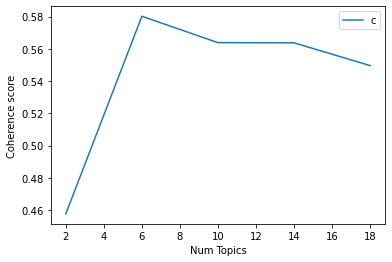

In [33]:
# Basic line chart
# Use a plotly or ggplot viz
limit=22; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " consists of a Coherence Value of", round(cv, 4))

Num Topics = 2  consists of a Coherence Value of 0.4576
Num Topics = 6  consists of a Coherence Value of 0.5802
Num Topics = 10  consists of a Coherence Value of 0.5638
Num Topics = 14  consists of a Coherence Value of 0.5637
Num Topics = 18  consists of a Coherence Value of 0.5496


In [30]:
# Select the model and print the topics
optimal_model =  models.LdaModel.load('tinder_lda4.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.121*"profile" + 0.077*"picture" + 0.056*"photo" + 0.049*"fake" + '
  '0.038*"upload" + 0.037*"add" + 0.027*"change" + 0.023*"far" + 0.018*"lot" + '
  '0.018*"bot"'),
 (1,
  '0.148*"good" + 0.119*"app" + 0.080*"open" + 0.039*"love" + 0.034*"connect" '
  '+ 0.029*"load" + 0.029*"pic" + 0.028*"near" + 0.027*"work" + 0.027*"gps"'),
 (2,
  '0.058*"tinder" + 0.048*"don" + 0.048*"account" + 0.042*"facebook" + '
  '0.038*"want" + 0.037*"use" + 0.032*"app" + 0.022*"pay" + 0.020*"money" + '
  '0.019*"month"'),
 (3,
  '0.071*"people" + 0.057*"app" + 0.050*"great" + 0.025*"mile" + 0.024*"cool" '
  '+ 0.024*"way" + 0.024*"meet" + 0.022*"away" + 0.020*"nice" + 0.019*"use"'),
 (4,
  '0.081*"message" + 0.031*"notification" + 0.029*"send" + 0.025*"get" + '
  '0.025*"tinder" + 0.021*"bad" + 0.019*"app" + 0.015*"receive" + 0.015*"don" '
  '+ 0.013*"time"'),
 (5,
  '0.079*"log" + 0.079*"problem" + 0.073*"fix" + 0.058*"fun" + 0.058*"login" + '
  '0.055*"go" + 0.052*"wrong" + 0.041*"say" + 0.036*"

/opt/anaconda3/envs/NNs/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/NNs/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/NNs/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/NNs/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/NNs/lib/python3.8/site-packages/past/builtins/misc.py:45: Deprecatio

In [31]:
# Get a cleaner print for readability
for id, t in enumerate(topics):
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
profile picture photo fake upload

------ Topic 1 ------
good app open love connect

------ Topic 2 ------
tinder don account facebook want

------ Topic 3 ------
people app great mile cool

------ Topic 4 ------
message notification send get tinder

------ Topic 5 ------
log problem fix fun login

------ Topic 6 ------
match get app message people

------ Topic 7 ------
app work crash time update

------ Topic 8 ------
log facebook let win sign

------ Topic 9 ------
like swipe app well right

